In [96]:
import os
import numpy as np
import pandas as pd
import math
import missingno as mso
import datetime as datetime
import calendar
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

from scipy import stats
from scipy.stats import norm, skew

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import KFold,train_test_split, cross_val_score, RandomizedSearchCV,GridSearchCV
from sklearn.metrics import fbeta_score,precision_score,recall_score,confusion_matrix, mean_absolute_error,mean_squared_error
from sklearn.linear_model import Lasso,Ridge, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from collections import OrderedDict
# from sklearn.grid_search import GridSearchCV
from xgboost import plot_importance
from xgboost.sklearn import XGBRegressor

In [97]:
ct_train = pd.read_csv('counterfeit_train.csv')
ct_test = pd.read_csv('counterfeit_test.csv')

In [98]:
ct_train.head()

,Medicine_ID,Counterfeit_Weight,DistArea_ID,Active_Since,Medicine_MRP,Medicine_Type,SidEffect_Level,Availability_rating,Area_Type,Area_City_Type,Area_dist_level,Counterfeit_Sales
0,RRA15,13.100,Area046,1995,160.2366,Antimalarial,critical,0.070422,DownTown,Tier 1,Small,1775.5026
1,YVV26,NaN,Area027,1983,110.4384,Mstablizers,mild,0.013000,CityLimits,Tier 3,Medium,3069.1520
2,LJC15,9.025,Area046,1995,259.4092,Cardiac,mild,0.060783,DownTown,Tier 1,Small,2603.0920
3,GWC40,11.800,Area046,1995,99.9830,OralContraceptives,mild,0.065555,DownTown,Tier 1,Small,1101.7130
4,QMN13,NaN,Area019,1983,56.4402,Hreplacements,critical,0.248859,MidTownResidential,Tier 1,Small,158.9402


In [100]:
ct_train['Counterfeit_Sales'].value_counts(ascending=True)

2077.1100     1
1967.9188     1
1450.5922     1
1125.6818     1
8526.0488     1
3870.7752     1
5591.2024     1
3698.3330     1
8873.5964     1
4693.7040     1
429.2550      1
3313.5006     1
732.8598      1
4294.2240     1
296.0950      1
1884.0280     1
7089.2524     1
4148.4138     1
3721.6360     1
6185.0960     1
1880.6990     1
5962.7188     1
1220.8912     1
6735.7126     1
1949.2764     1
2371.3936     1
6189.0908     1
3684.3512     1
1944.6158     1
783.4606      1
             ..
1417.9680     8
1551.1280     9
2126.3792     9
1806.7952     9
2390.0360     9
3069.1520     9
640.3136      9
868.0172      9
2797.5056     9
1119.6896     9
560.4176      9
2461.9424     9
1583.0864     9
3528.5540     9
1519.1696     9
2872.0752     9
1650.9980    10
652.2980     10
1631.0240    10
3133.0688    10
1684.2880    10
872.0120     10
1529.8224    11
1343.3984    11
1324.7560    12
1958.5976    12
1391.3360    13
816.0848     13
1071.7520    14
1455.2528    16
Name: Counterfeit_Sales,

In [4]:
# shape of train dataset and test dataset
print('Train dataset shape : {}'.format(ct_train.shape))
print('Test dataset shape : {}'.format(ct_test.shape))

Train dataset shape : (6818, 12)
Test dataset shape : (1705, 11)


In [5]:
# Need to concat both train and test dataset for preprocessing
# undergo the same preprocessing as the data on which the predictions are made
ct_train['data'] = 'Train'
ct_test['data'] = 'Test'

ct_test['Counterfeit_Sales'] = np.nan

In [6]:
# check shape after adding data columns
print('Train data shape after adding data column : ',ct_train.shape)
print('Test data shape after adding data column : ',ct_test.shape)

Train data shape after adding data column :  (6818, 13)
Test data shape after adding data column :  (1705, 13)


In [7]:
ct_test = ct_test[ct_train.columns] # Both should be of same order to concat

ct_all = pd.concat([ct_train,ct_test],axis=0)
ct_all.reset_index(drop=True,inplace=True)

In [8]:
# checking shape after concatination
print('Shape of dataset after combining both train and test data : ',ct_all.shape)

Shape of dataset after combining both train and test data :  (8523, 13)


In [9]:
ct_all.head()

,Medicine_ID,Counterfeit_Weight,DistArea_ID,Active_Since,Medicine_MRP,Medicine_Type,SidEffect_Level,Availability_rating,Area_Type,Area_City_Type,Area_dist_level,Counterfeit_Sales,data
0,RRA15,13.100,Area046,1995,160.2366,Antimalarial,critical,0.070422,DownTown,Tier 1,Small,1775.5026,Train
1,YVV26,NaN,Area027,1983,110.4384,Mstablizers,mild,0.013000,CityLimits,Tier 3,Medium,3069.1520,Train
2,LJC15,9.025,Area046,1995,259.4092,Cardiac,mild,0.060783,DownTown,Tier 1,Small,2603.0920,Train
3,GWC40,11.800,Area046,1995,99.9830,OralContraceptives,mild,0.065555,DownTown,Tier 1,Small,1101.7130,Train
4,QMN13,NaN,Area019,1983,56.4402,Hreplacements,critical,0.248859,MidTownResidential,Tier 1,Small,158.9402,Train


In [10]:
ct_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 13 columns):
Medicine_ID            8523 non-null object
Counterfeit_Weight     7060 non-null float64
DistArea_ID            8523 non-null object
Active_Since           8523 non-null int64
Medicine_MRP           8523 non-null float64
Medicine_Type          8523 non-null object
SidEffect_Level        8523 non-null object
Availability_rating    8523 non-null float64
Area_Type              8523 non-null object
Area_City_Type         8523 non-null object
Area_dist_level        8523 non-null object
Counterfeit_Sales      6818 non-null float64
data                   8523 non-null object
dtypes: float64(4), int64(1), object(8)
memory usage: 865.7+ KB


In [11]:
ct_all.describe()

,Counterfeit_Weight,Active_Since,Medicine_MRP,Availability_rating,Counterfeit_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,6818.000000
mean,14.157645,1995.831867,151.292782,0.079132,2280.583480
std,4.643456,8.371760,62.275067,0.051598,1693.354404
min,5.855000,1983.000000,41.590000,0.013000,146.290000
25%,10.073750,1985.000000,104.126500,0.039989,933.265600
50%,13.900000,1997.000000,153.312800,0.066931,1902.670400
75%,18.150000,2002.000000,195.943700,0.107585,3207.638400
max,22.650000,2007.000000,277.188400,0.341391,13199.964800


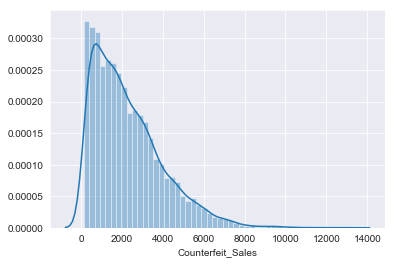

In [12]:
target =ct_train['Counterfeit_Sales']
sns.distplot(target)

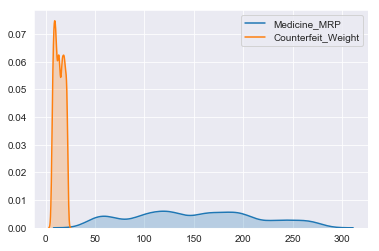

In [13]:
sns.kdeplot(ct_train['Medicine_MRP'], shade=True)
sns.kdeplot(ct_train['Counterfeit_Weight'], shade=True);

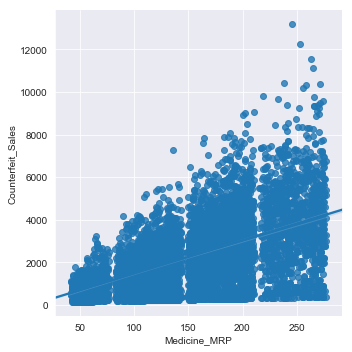

In [14]:
sns.lmplot('Medicine_MRP', 'Counterfeit_Sales', 
           data=ct_train,palette="Set1")
# lmplot function by default gives a regression line (linear relationship) between the two variables

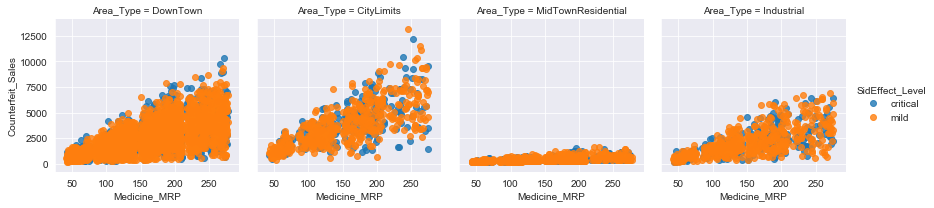

In [15]:
sns.lmplot('Medicine_MRP', 'Counterfeit_Sales', hue="SidEffect_Level",col="Area_Type",data=ct_train,fit_reg=False,size=3)

In [16]:
ct_all.isnull().sum()

Medicine_ID               0
Counterfeit_Weight     1463
DistArea_ID               0
Active_Since              0
Medicine_MRP              0
Medicine_Type             0
SidEffect_Level           0
Availability_rating       0
Area_Type                 0
Area_City_Type            0
Area_dist_level           0
Counterfeit_Sales      1705
data                      0
dtype: int64

In counterfeit_Sales null values are those which we have added for preprocessing on bot dataset and to conact and 
for Counterfeit_Weight we will treat 

In [17]:
all_data_na = (ct_all.isnull().sum()/len(ct_all)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na==0].index).sort_values(ascending=False)[:30]
pd.DataFrame({'Missing Ratio':all_data_na})

,Missing Ratio
Counterfeit_Sales,20.004693
Counterfeit_Weight,17.165317


In [18]:
# checking dtypes of columns
ct_all.dtypes

Medicine_ID             object
Counterfeit_Weight     float64
DistArea_ID             object
Active_Since             int64
Medicine_MRP           float64
Medicine_Type           object
SidEffect_Level         object
Availability_rating    float64
Area_Type               object
Area_City_Type          object
Area_dist_level         object
Counterfeit_Sales      float64
data                    object
dtype: object

In [19]:
for col in ct_all.select_dtypes(['object']).columns:
    print(col,";",ct_all[col].nunique())

Medicine_ID ; 1557
DistArea_ID ; 10
Medicine_Type ; 16
SidEffect_Level ; 2
Area_Type ; 4
Area_City_Type ; 3
Area_dist_level ; 4
data ; 2


In [20]:
ct_all['Medicine_Type'].value_counts()

Antibiotics           1232
Hreplacements         1200
Antiseptics            910
OralContraceptives     856
Antipyretics           682
Cardiac                649
Mstablizers            648
Tranquilizers          520
Analgesics             445
Antimalarial           425
Antacids               251
Statins                214
MuscleRelaxants        169
Antifungal             148
Stimulants             110
Antiviral               64
Name: Medicine_Type, dtype: int64

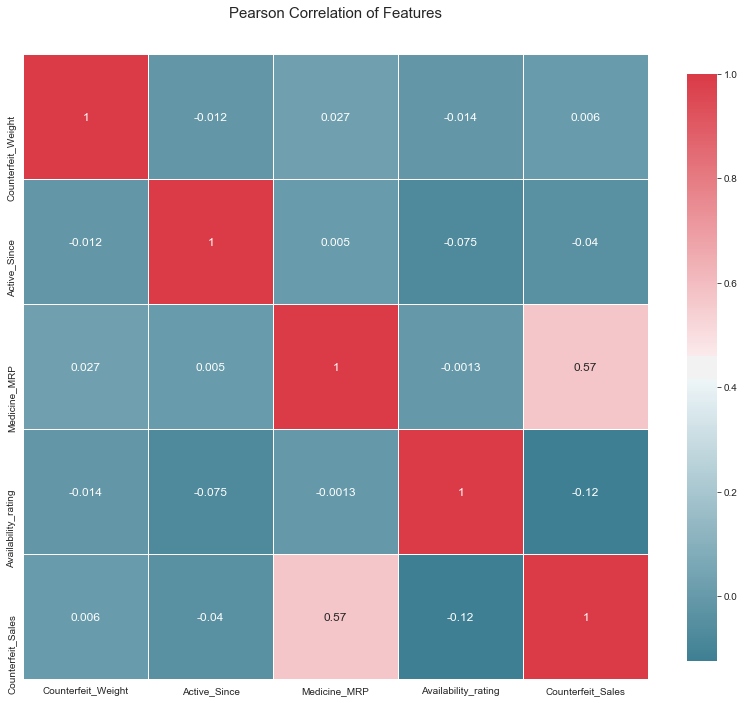

In [21]:
#correlation heatmap of dataset
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(ct_all)

In [22]:
ct_all.columns

Index(['Medicine_ID', 'Counterfeit_Weight', 'DistArea_ID', 'Active_Since',
       'Medicine_MRP', 'Medicine_Type', 'SidEffect_Level',
       'Availability_rating', 'Area_Type', 'Area_City_Type', 'Area_dist_level',
       'Counterfeit_Sales', 'data'],
      dtype='object')

In [23]:
ct_all['SidEffect_Level'].value_counts()

mild        5517
critical    3006
Name: SidEffect_Level, dtype: int64

In [24]:
ct_all['SidEffect_Level'] = np.where(ct_all['SidEffect_Level']== 'mild',0,1)

In [25]:
ct_all['DistArea_ID'].value_counts()

Area027    935
Area013    932
Area035    930
Area046    930
Area049    930
Area045    929
Area018    928
Area017    926
Area010    555
Area019    528
Name: DistArea_ID, dtype: int64

In [26]:
Area_Dummies = pd.get_dummies(ct_all['DistArea_ID'])
del ct_all['DistArea_ID'] # dropping column
Area_Dummies.head()

,Area010,Area013,Area017,Area018,Area019,Area027,Area035,Area045,Area046,Area049
0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,1,0,0,0,0,0


In [27]:
ct_all.head()

,Medicine_ID,Counterfeit_Weight,Active_Since,Medicine_MRP,Medicine_Type,SidEffect_Level,Availability_rating,Area_Type,Area_City_Type,Area_dist_level,Counterfeit_Sales,data
0,RRA15,13.100,1995,160.2366,Antimalarial,1,0.070422,DownTown,Tier 1,Small,1775.5026,Train
1,YVV26,NaN,1983,110.4384,Mstablizers,0,0.013000,CityLimits,Tier 3,Medium,3069.1520,Train
2,LJC15,9.025,1995,259.4092,Cardiac,0,0.060783,DownTown,Tier 1,Small,2603.0920,Train
3,GWC40,11.800,1995,99.9830,OralContraceptives,0,0.065555,DownTown,Tier 1,Small,1101.7130,Train
4,QMN13,NaN,1983,56.4402,Hreplacements,1,0.248859,MidTownResidential,Tier 1,Small,158.9402,Train


In [28]:
ct_all = pd.concat([ct_all,Area_Dummies],axis=1)
ct_all.head()

,Medicine_ID,Counterfeit_Weight,Active_Since,Medicine_MRP,Medicine_Type,SidEffect_Level,Availability_rating,Area_Type,Area_City_Type,Area_dist_level,...,Area010,Area013,Area017,Area018,Area019,Area027,Area035,Area045,Area046,Area049
0,RRA15,13.100,1995,160.2366,Antimalarial,1,0.070422,DownTown,Tier 1,Small,...,0,0,0,0,0,0,0,0,1,0
1,YVV26,NaN,1983,110.4384,Mstablizers,0,0.013000,CityLimits,Tier 3,Medium,...,0,0,0,0,0,1,0,0,0,0
2,LJC15,9.025,1995,259.4092,Cardiac,0,0.060783,DownTown,Tier 1,Small,...,0,0,0,0,0,0,0,0,1,0
3,GWC40,11.800,1995,99.9830,OralContraceptives,0,0.065555,DownTown,Tier 1,Small,...,0,0,0,0,0,0,0,0,1,0
4,QMN13,NaN,1983,56.4402,Hreplacements,1,0.248859,MidTownResidential,Tier 1,Small,...,0,0,0,0,1,0,0,0,0,0


In [29]:
print('Area Type: ',ct_all['Area_Type'].value_counts())
AreaType_Dummies = pd.get_dummies(ct_all['Area_Type'])
ct_all = pd.concat([ct_all,AreaType_Dummies],axis=1)

del ct_all['Area_Type']
ct_all.head()

Area Type:  DownTown              5577
MidTownResidential    1083
CityLimits             935
Industrial             928
Name: Area_Type, dtype: int64


,Medicine_ID,Counterfeit_Weight,Active_Since,Medicine_MRP,Medicine_Type,SidEffect_Level,Availability_rating,Area_City_Type,Area_dist_level,Counterfeit_Sales,...,Area019,Area027,Area035,Area045,Area046,Area049,CityLimits,DownTown,Industrial,MidTownResidential
0,RRA15,13.100,1995,160.2366,Antimalarial,1,0.070422,Tier 1,Small,1775.5026,...,0,0,0,0,1,0,0,1,0,0
1,YVV26,NaN,1983,110.4384,Mstablizers,0,0.013000,Tier 3,Medium,3069.1520,...,0,1,0,0,0,0,1,0,0,0
2,LJC15,9.025,1995,259.4092,Cardiac,0,0.060783,Tier 1,Small,2603.0920,...,0,0,0,0,1,0,0,1,0,0
3,GWC40,11.800,1995,99.9830,OralContraceptives,0,0.065555,Tier 1,Small,1101.7130,...,0,0,0,0,1,0,0,1,0,0
4,QMN13,NaN,1983,56.4402,Hreplacements,1,0.248859,Tier 1,Small,158.9402,...,1,0,0,0,0,0,0,0,0,1


In [30]:
ct_all.dtypes

Medicine_ID             object
Counterfeit_Weight     float64
Active_Since             int64
Medicine_MRP           float64
Medicine_Type           object
SidEffect_Level          int32
Availability_rating    float64
Area_City_Type          object
Area_dist_level         object
Counterfeit_Sales      float64
data                    object
Area010                  uint8
Area013                  uint8
Area017                  uint8
Area018                  uint8
Area019                  uint8
Area027                  uint8
Area035                  uint8
Area045                  uint8
Area046                  uint8
Area049                  uint8
CityLimits               uint8
DownTown                 uint8
Industrial               uint8
MidTownResidential       uint8
dtype: object

In [31]:
ct_all.groupby('Medicine_Type')['Counterfeit_Weight'].mean()

Medicine_Type
Analgesics            13.147460
Antacids              12.646936
Antibiotics           14.524769
Antifungal            14.990731
Antimalarial          14.117344
Antipyretics          14.726069
Antiseptics           14.684736
Antiviral             13.852843
Cardiac               13.605705
Hreplacements         14.287880
Mstablizers           13.577108
MuscleRelaxants       15.153285
OralContraceptives    14.167061
Statins               12.700328
Stimulants            14.068202
Tranquilizers         14.442314
Name: Counterfeit_Weight, dtype: float64

In [32]:
ct_all['Counterfeit_Weight'].mean()

14.15764518413612

In [33]:
ct_train.Counterfeit_Weight.mean()

14.115056617126996

In [34]:
ct_all['Counterfeit_Weight'] = ct_all['Counterfeit_Weight'].fillna(ct_all['Counterfeit_Weight'].mean())

In [35]:
ct_train.groupby('Area_Type')['Counterfeit_Sales'].sum()

Area_Type
CityLimits            2.772607e+06
DownTown              1.084975e+07
Industrial            1.535692e+06
MidTownResidential    3.909705e+05
Name: Counterfeit_Sales, dtype: float64

In [36]:
ct_train.groupby('Medicine_Type')['Counterfeit_Sales'].sum()

Medicine_Type
Analgesics            7.444819e+05
Antacids              4.655350e+05
Antibiotics           2.325286e+06
Antifungal            2.712902e+05
Antimalarial          7.433200e+05
Antipyretics          1.228900e+06
Antiseptics           1.713413e+06
Antiviral             1.265748e+05
Cardiac               1.233477e+06
Hreplacements         2.319091e+06
Mstablizers           1.051063e+06
MuscleRelaxants       2.906618e+05
OralContraceptives    1.558180e+06
Statins               3.856775e+05
Stimulants            2.165970e+05
Tranquilizers         8.754689e+05
Name: Counterfeit_Sales, dtype: float64

Text(0,0.5,'Medicine_MRP')

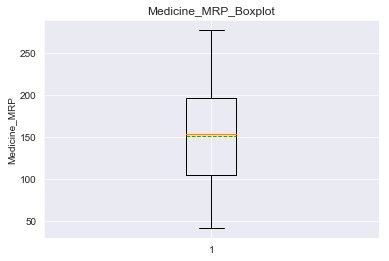

In [37]:
plt.boxplot(ct_train['Medicine_MRP'], showmeans=True , meanline=True)
plt.title('Medicine_MRP_Boxplot')
plt.ylabel('Medicine_MRP')

In [38]:
ct_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 25 columns):
Medicine_ID            8523 non-null object
Counterfeit_Weight     8523 non-null float64
Active_Since           8523 non-null int64
Medicine_MRP           8523 non-null float64
Medicine_Type          8523 non-null object
SidEffect_Level        8523 non-null int32
Availability_rating    8523 non-null float64
Area_City_Type         8523 non-null object
Area_dist_level        8523 non-null object
Counterfeit_Sales      6818 non-null float64
data                   8523 non-null object
Area010                8523 non-null uint8
Area013                8523 non-null uint8
Area017                8523 non-null uint8
Area018                8523 non-null uint8
Area019                8523 non-null uint8
Area027                8523 non-null uint8
Area035                8523 non-null uint8
Area045                8523 non-null uint8
Area046                8523 non-null uint8
Area049             

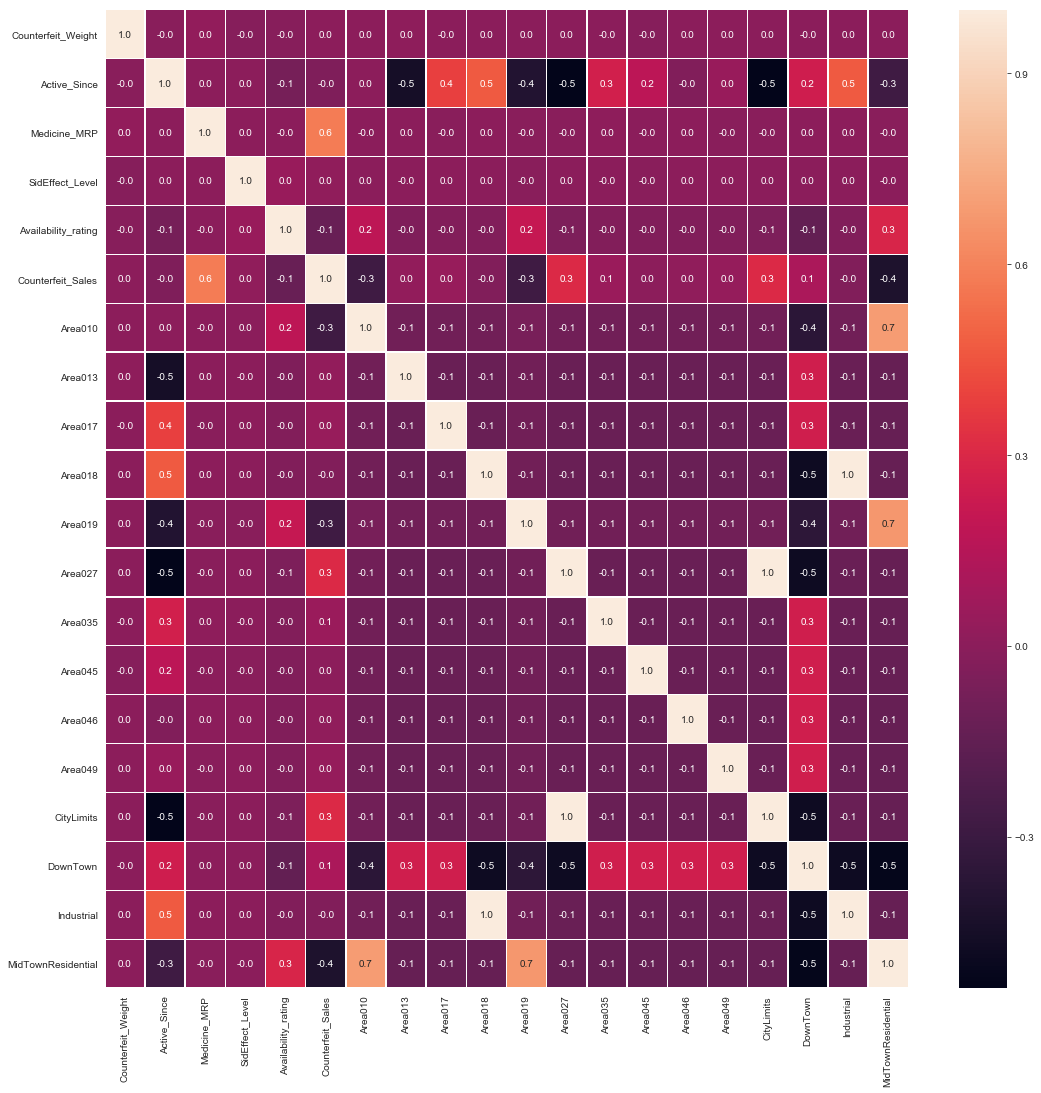

In [39]:
#correlation map
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(ct_all.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

In [40]:
for col in ct_all.select_dtypes(['object']).columns:
    print(col,':',ct_all[col].nunique())

Medicine_ID : 1557
Medicine_Type : 16
Area_City_Type : 3
Area_dist_level : 4
data : 2


In [41]:
ct_all['Medicine_Type'].value_counts()

Antibiotics           1232
Hreplacements         1200
Antiseptics            910
OralContraceptives     856
Antipyretics           682
Cardiac                649
Mstablizers            648
Tranquilizers          520
Analgesics             445
Antimalarial           425
Antacids               251
Statins                214
MuscleRelaxants        169
Antifungal             148
Stimulants             110
Antiviral               64
Name: Medicine_Type, dtype: int64

In [42]:
for col in ['Medicine_Type']:
    freqs=ct_all[col].value_counts()
    selected_cats=freqs.index[freqs>300][:-1]
    
    print(col)
    for cat in selected_cats:
        name=col+'_'+cat
        
        ct_all[name]=(ct_all[col]==cat).astype(int)
    del ct_all[col]

Medicine_Type


In [43]:
ct_all.head()

,Medicine_ID,Counterfeit_Weight,Active_Since,Medicine_MRP,SidEffect_Level,Availability_rating,Area_City_Type,Area_dist_level,Counterfeit_Sales,data,...,MidTownResidential,Medicine_Type_Antibiotics,Medicine_Type_Hreplacements,Medicine_Type_Antiseptics,Medicine_Type_OralContraceptives,Medicine_Type_Antipyretics,Medicine_Type_Cardiac,Medicine_Type_Mstablizers,Medicine_Type_Tranquilizers,Medicine_Type_Analgesics
0,RRA15,13.100000,1995,160.2366,1,0.070422,Tier 1,Small,1775.5026,Train,...,0,0,0,0,0,0,0,0,0,0
1,YVV26,14.157645,1983,110.4384,0,0.013000,Tier 3,Medium,3069.1520,Train,...,0,0,0,0,0,0,0,1,0,0
2,LJC15,9.025000,1995,259.4092,0,0.060783,Tier 1,Small,2603.0920,Train,...,0,0,0,0,0,0,1,0,0,0
3,GWC40,11.800000,1995,99.9830,0,0.065555,Tier 1,Small,1101.7130,Train,...,0,0,0,0,1,0,0,0,0,0
4,QMN13,14.157645,1983,56.4402,1,0.248859,Tier 1,Small,158.9402,Train,...,1,0,1,0,0,0,0,0,0,0


In [44]:
print(ct_all['Area_City_Type'].value_counts())
AreaCityType_Dummies = pd.get_dummies(ct_all['Area_City_Type'])
ct_all = pd.concat([ct_all,AreaCityType_Dummies],axis=1)

del ct_all['Area_City_Type']

Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Area_City_Type, dtype: int64


In [45]:
ct_all.head()

,Medicine_ID,Counterfeit_Weight,Active_Since,Medicine_MRP,SidEffect_Level,Availability_rating,Area_dist_level,Counterfeit_Sales,data,Area010,...,Medicine_Type_Antiseptics,Medicine_Type_OralContraceptives,Medicine_Type_Antipyretics,Medicine_Type_Cardiac,Medicine_Type_Mstablizers,Medicine_Type_Tranquilizers,Medicine_Type_Analgesics,Tier 1,Tier 2,Tier 3
0,RRA15,13.100000,1995,160.2366,1,0.070422,Small,1775.5026,Train,0,...,0,0,0,0,0,0,0,1,0,0
1,YVV26,14.157645,1983,110.4384,0,0.013000,Medium,3069.1520,Train,0,...,0,0,0,0,1,0,0,0,0,1
2,LJC15,9.025000,1995,259.4092,0,0.060783,Small,2603.0920,Train,0,...,0,0,0,1,0,0,0,1,0,0
3,GWC40,11.800000,1995,99.9830,0,0.065555,Small,1101.7130,Train,0,...,0,1,0,0,0,0,0,1,0,0
4,QMN13,14.157645,1983,56.4402,1,0.248859,Small,158.9402,Train,0,...,0,0,0,0,0,0,0,1,0,0


In [46]:
print(ct_all['Area_dist_level'].value_counts())
AreaDistLevel_Dummies = pd.get_dummies(ct_all['Area_dist_level'])
ct_all = pd.concat([ct_all,AreaDistLevel_Dummies],axis = 1)

del ct_all['Area_dist_level']

Medium     2793
Unknown    2410
Small      2388
High        932
Name: Area_dist_level, dtype: int64


In [48]:
del ct_all['Medicine_ID']

In [49]:
# separating both train and test data which merged for preproessing
ct_train = ct_all[ct_all['data']=='Train']
ct_test = ct_all[ct_all['data']=='Test']

ct_train.drop(['data'],axis=1,inplace= True)
ct_test.drop(["Counterfeit_Sales",'data'],axis=1,inplace=True)

In [50]:
ct_train.reset_index(drop=True,inplace=True)
ct_test.reset_index(drop=True, inplace= True)

In [51]:
x = ct_train.drop(['Counterfeit_Sales'],1)
y = ct_train['Counterfeit_Sales']

In [52]:
print(x.shape)
print(y.shape)

(6818, 35)
(6818,)


In [53]:
x_train, x_test,y_train,y_test = train_test_split(x,y,test_size=0.20,random_state=2)

In [54]:
print(x_train.shape)
print(y_train.shape)

(5454, 35)
(5454,)


In [55]:
x_train.dtypes

Counterfeit_Weight                  float64
Active_Since                          int64
Medicine_MRP                        float64
SidEffect_Level                       int32
Availability_rating                 float64
Area010                               uint8
Area013                               uint8
Area017                               uint8
Area018                               uint8
Area019                               uint8
Area027                               uint8
Area035                               uint8
Area045                               uint8
Area046                               uint8
Area049                               uint8
CityLimits                            uint8
DownTown                              uint8
Industrial                            uint8
MidTownResidential                    uint8
Medicine_Type_Antibiotics             int32
Medicine_Type_Hreplacements           int32
Medicine_Type_Antiseptics             int32
Medicine_Type_OralContraceptives

# Using Random Forest with default parameter

In [65]:
rf_model = RandomForestRegressor()
rf_model.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [66]:
predicted = rf_model.predict(x_test)
residuals = predicted-y_test

rmse = np.sqrt(np.dot(residuals,residuals)/len(predicted))
print('RMSE of model            :{} '.format(rmse))

MAE = mean_absolute_error(y_test,predicted)
print('MAE of model       : {}'.format(MAE))

RMSE of model            :1144.2965629734567 
MAE of model       : 802.844449995601


In [67]:
passing_score = 1-(MAE/1660)
print('Score   :{}'.format(passing_score)  )

Score   :0.5163587650628909


Feature ranking:
1. feature Counterfeit_Weight (0.448629)
2. feature Active_Since (0.195145)
3. feature Medicine_MRP (0.102849)
4. feature SidEffect_Level (0.058175)
5. feature Availability_rating (0.044840)
6. feature Area010 (0.023216)
7. feature Area013 (0.021716)
8. feature Area017 (0.008957)
9. feature Area018 (0.008129)
10. feature Area019 (0.008085)
11. feature Area027 (0.007053)
12. feature Area035 (0.006731)
13. feature Area045 (0.006200)
14. feature Area046 (0.005282)
15. feature Area049 (0.004359)
16. feature CityLimits (0.004167)
17. feature DownTown (0.003959)
18. feature Industrial (0.003829)
19. feature MidTownResidential (0.003767)
20. feature Medicine_Type_Antibiotics (0.003556)
21. feature Medicine_Type_Hreplacements (0.003448)
22. feature Medicine_Type_Antiseptics (0.003442)
23. feature Medicine_Type_OralContraceptives (0.003257)
24. feature Medicine_Type_Antipyretics (0.003145)
25. feature Medicine_Type_Cardiac (0.002975)
26. feature Medicine_Type_Mstablizers (0.002

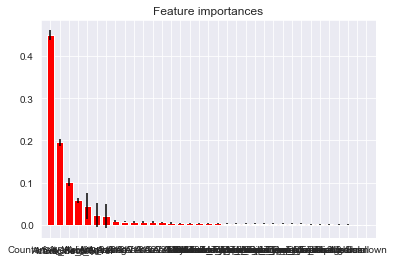

In [68]:
importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(x_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, list(x_train.columns)[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train.shape[1]), list(x_train.columns))
plt.xlim([-1, x_train.shape[1]])
plt.show()

# XGBoost

In [69]:
from xgboost import XGBRFRegressor

In [70]:
xgb_model = XGBRFRegressor()
xgb_model.fit(x_train,y_train)

[16:42:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRFRegressor(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
               colsample_bytree=1, gamma=0, learning_rate=1, max_delta_step=0,
               max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
               n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
               silent=None, subsample=0.8, verbosity=1)

In [75]:
xgb_prediction = xgb_model.predict(x_test)
residual_xgb = xgb_prediction-y_test

rmse_1 = np.sqrt(np.dot(residual_xgb,residual_xgb)/len(xgb_prediction))
print('RMSE   : {}'.format(rmse_1))

MAE_1 = mean_absolute_error(y_test,xgb_prediction)
print('MAE  :{}'.format(MAE_1))

RMSE   : 1159.554641869059
MAE  :825.9849114855277


In [76]:
passing_score = 1-(MAE_1/1660)
print('Score   :{}'.format(passing_score)  )

Score   :0.5024187280207664


In [77]:
xg_model = XGBRegressor(eval_metric='mae')

xgb_params = {  
                "learning_rate":[0.01,0.05,0.1,0.3],
                "gamma":[i/10.0 for i in range(0,5)],
                "max_depth": [2,3,4,5,6,7],
                "min_child_weight":[1,2,5,10],
                "max_delta_step":[0,1,2,5,10],
                "subsample":[i/10.0 for i in range(5,10)],
                "colsample_bytree":[i/10.0 for i in range(5,10)],
                "colsample_bylevel":[i/10.0 for i in range(5,10)],
                "reg_lambda":[1e-5, 1e-2, 0.1, 1, 10], 
                "reg_alpha":[1e-5, 1e-2, 0.1, 1, 10],
                "scale_pos_weight":[1,2,3,4,5,6,7,8,9],
                "n_estimators":[100,500,700,1000]
             }


n_iter=4

random_search=RandomizedSearchCV(xg_model,n_jobs=-1,verbose=3,cv=5,n_iter=n_iter,
                                 param_distributions=xgb_params)

random_search.fit(x_train,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   51.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   51.5s finished


[19:29:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, eval_metric='mae',
                                          gamma=0, importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          random_...
                                        'max_delta_step': [0, 1, 2, 5, 10],
                                        'max_depth': [2, 3, 4, 5, 6, 7],
                                       

In [78]:
random_search.best_params_

{'colsample_bylevel': 0.9,
 'colsample_bytree': 0.9,
 'gamma': 0.3,
 'learning_rate': 0.3,
 'max_delta_step': 10,
 'max_depth': 3,
 'min_child_weight': 5,
 'n_estimators': 500,
 'reg_alpha': 1e-05,
 'reg_lambda': 0.01,
 'scale_pos_weight': 5,
 'subsample': 0.6}

In [79]:
random_search.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
             colsample_bynode=1, colsample_bytree=0.9, eval_metric='mae',
             gamma=0.3, importance_type='gain', learning_rate=0.3,
             max_delta_step=10, max_depth=3, min_child_weight=5, missing=None,
             n_estimators=500, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=1e-05, reg_lambda=0.01,
             scale_pos_weight=5, seed=None, silent=None, subsample=0.6,
             verbosity=1)

In [92]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.5f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

report(random_search.cv_results_,5)

Model with rank: 1
Mean validation score: -0.143 (std: 0.03243)
Parameters: {'subsample': 0.6, 'scale_pos_weight': 5, 'reg_lambda': 0.01, 'reg_alpha': 1e-05, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 3, 'max_delta_step': 10, 'learning_rate': 0.3, 'gamma': 0.3, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.9}

Model with rank: 2
Mean validation score: -1.206 (std: 0.04450)
Parameters: {'subsample': 0.9, 'scale_pos_weight': 5, 'reg_lambda': 0.01, 'reg_alpha': 0.1, 'n_estimators': 700, 'min_child_weight': 5, 'max_depth': 5, 'max_delta_step': 2, 'learning_rate': 0.3, 'gamma': 0.0, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.6}

Model with rank: 3
Mean validation score: -1.657 (std: 0.04549)
Parameters: {'subsample': 0.7, 'scale_pos_weight': 3, 'reg_lambda': 0.01, 'reg_alpha': 0.1, 'n_estimators': 1000, 'min_child_weight': 2, 'max_depth': 5, 'max_delta_step': 2, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.8}

Model with rank: 4
M

In [83]:
#after best parameter is learnt
xgb_best=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
             colsample_bynode=1, colsample_bytree=0.9, eval_metric='mae',
             gamma=0.3, importance_type='gain', learning_rate=0.3,
             max_delta_step=10, max_depth=3, min_child_weight=5, missing=None,
             n_estimators=500, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=1e-05, reg_lambda=0.01,
             scale_pos_weight=5, seed=None, silent=None, subsample=0.6,
             verbosity=1)

In [88]:
xgb_best.fit(x_train,y_train,eval_metric='mae')

[21:21:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
             colsample_bynode=1, colsample_bytree=0.5, eval_metric='mae',
             gamma=0.3, importance_type='gain', learning_rate=0.05,
             max_delta_step=0, max_depth=8, min_child_weight=1, missing=None,
             n_estimators=100, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0.1, reg_lambda=0.1, scale_pos_weight=6,
             seed=None, silent=None, subsample=0.8, verbosity=1)

In [89]:
predicted= xgb_best.predict(x_test)
residual= predicted-y_test


rmse_2=np.sqrt(np.dot(residual,residual)/len(predicted))
print("RMSE of the model is                 : {} ".format(rmse_2))

MAE_2 = mean_absolute_error(y_test,predicted)
print("Mean Absolute Error of the model is     : {} ".format(MAE_2))

RMSE of the model is                 : 1120.108381244579 
Mean Absolute Error of the model is     : 776.1841871068066 


In [90]:
passing_score = 1-(MAE_2/1660)
print('Score   :{}'.format(passing_score)  )

Score   :0.53241916439349


In [94]:
xgb_best.fit(x,y,eval_metric='mae')
predictions = xgb_best.predict(ct_test)

[23:07:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [95]:
# saveb test data prediction in csv format
pd.DataFrame(predictions,columns=['Counterfeit_Sales']).to_csv('Project3_part2.csv',index=False)